In [88]:
#import libraries

#data manipulation
import numpy as np 
import pandas as pd
from datetime import timedelta, datetime

#graphing
import matplotlib.pyplot as plt
import seaborn as sns 

#modeling
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
from xgboost import XGBClassifier

#stats
import math 
import statsmodels.api as sm
import statsmodels.formula.api as smf



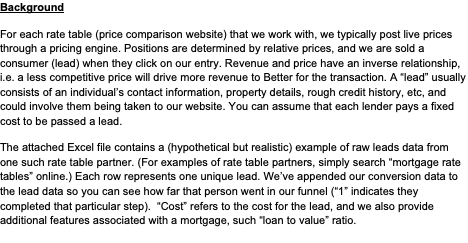

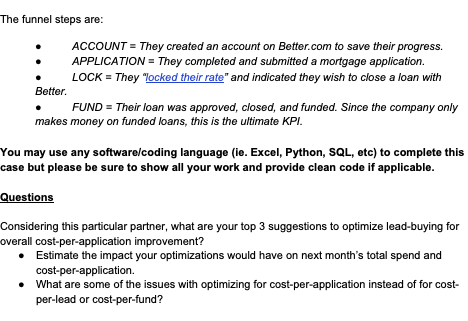

In [336]:
#reading in our data
data = pd.read_excel('Better_Case_Raw_Data (1).xlsx')

In [337]:
#converting columns names to lowercase
data.columns = map(str.lower, data.columns)

In [6]:
#viewing data
pd.set_option('display.max_columns', 50)
data.head()

,lead_created_timestamp,mortgage_type,user_id,cost,state,loan_amt,loan_to_value,is_cashout,cashout_amt,self_reported_credit,est_credit_score,lead,account,application,lock,fund,denied
0,2018-01-11 15:33:54.464,purchase,139946898,40,NJ,157500.0,70.0,0,NaN,EXCELLENT,759,1,0,0,0,0,0
1,2018-01-11 15:34:01.316,purchase,139946900,41,NC,202500.0,90.0,0,NaN,EXCELLENT,729,1,1,0,0,0,0
2,2018-01-11 15:35:56.270,purchase,139946978,46,CO,427500.0,90.0,0,NaN,EXCELLENT,699,1,0,0,0,0,0
3,2018-01-11 15:41:03.710,purchase,139947213,40,NJ,202500.0,90.0,0,NaN,EXCELLENT,769,1,0,0,0,0,0
4,2018-01-11 15:41:23.959,purchase,139947222,49,TX,180500.0,95.0,0,NaN,EXCELLENT,739,1,0,0,0,0,0


### Exploratory Data Analysis

#### *Observation: Application* 

We immediately notice high class imbalance in the application variable that will need to be addressed later on in our model building phase

In [169]:
#looking at application class imbalance
data.application.value_counts()

0    79732
1     3165
Name: application, dtype: int64

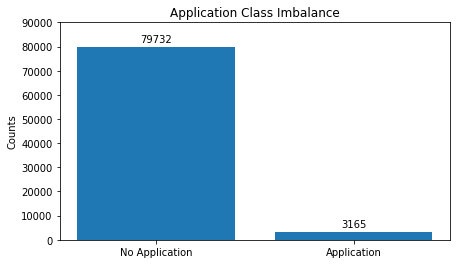

In [173]:
#visualizing class imbalance in application variable

plt.figure(figsize = (7,4))
plt.bar(['No Application','Application'], [79732,3165])
plt.title('Application Class Imbalance')
plt.ylabel('Counts')
for x,y in zip(['No Application','Application'], [79732,3165]):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,90000)
plt.show()

In [21]:
#looking at distribution of mortgage type
data.mortgage_type.value_counts()

purchase     51399
refinance    31498
Name: mortgage_type, dtype: int64

In [23]:
#checking if any repeat customers in the dataset
data.shape[0] - data.user_id.nunique()

0

In [338]:
#dropping user_id column to avoid our models potentially overfitting noise later on 

data.drop(['user_id'], axis = 1, inplace = True)

Text(0, 0.5, 'Count')

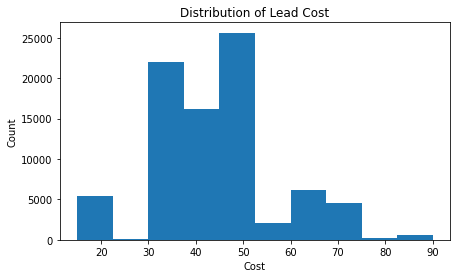

In [202]:
#looking at distribution of lead cost in the dataset
plt.figure(figsize = (7,4))
_ = plt.hist(data.cost)
plt.title('Distribution of Lead Cost')
plt.xlabel('Cost')
plt.ylabel('Count')

#### *Observation: State*

We notice that only 19 states are present in our data. This will reduce some of the expected differences by region as while there appears to be reprentation from all regions, the Northeast only has NJ, PA and CT represented in the dataset, while the West only has WA, CA and AZ

Text(0, 0.5, 'Count')

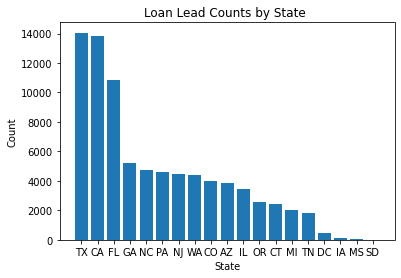

In [36]:
#looking at top states in dataset
states_df = data.state.value_counts().reset_index()
states_df.rename({'index':'state','state':'count'}, axis = 1, inplace = True)
plt.figure(figsize = (6,4))
_ = plt.bar(states_df['state'],states_df['count'])
plt.title('Loan Lead Counts by State ')
plt.xlabel('State')
plt.ylabel('Count')
#plt.hist(states_df)

(array([-250000.,       0.,  250000.,  500000.,  750000., 1000000.,
        1250000., 1500000., 1750000., 2000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

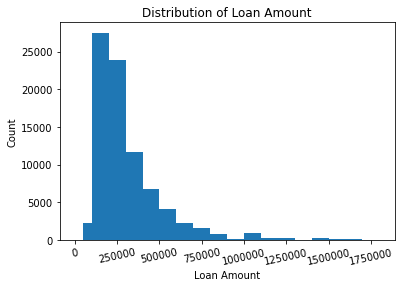

In [58]:
#looking at distribution of loan amount
_ = plt.hist(data.loan_amt, bins = [0,50000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,
                               1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000])
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.xticks(rotation=12)

Text(0, 0.5, 'Count')

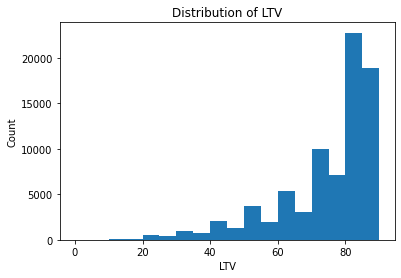

In [63]:
#looking at distribution of LTV

_ = plt.hist(data.loan_to_value, bins = list(range(0,95,5)))
plt.title('Distribution of LTV')
plt.xlabel('LTV')
plt.ylabel('Count')

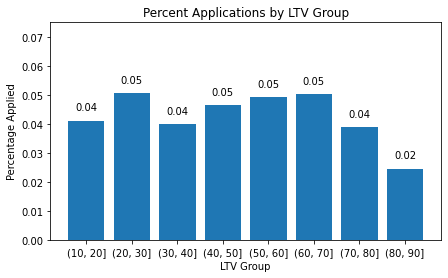

In [220]:
#looking at percent application rates by LTV group
bins = list(range(10,100,10))
ltv_groups = data.groupby([pd.cut(data.loan_to_value, bins)])['application'].sum() / data.groupby([pd.cut(data.loan_to_value, bins)])['application'].size()
ltv_groups = ltv_groups.reset_index()

#creating LTV vs Application Rate chart
plt.figure(figsize = (7,4))
plt.bar(ltv_groups['loan_to_value'].astype(str), ltv_groups['application'])
plt.title('Percent Applications by LTV Group')
plt.xlabel('LTV Group')
plt.ylabel('Percentage Applied')
for x,y in zip(ltv_groups['loan_to_value'].astype(str),ltv_groups['application']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,0.075)
plt.show()


In [191]:
#looking at cash out refinance by mortgage type 
data.groupby(['mortgage_type'])[['is_cashout']].count()

,is_cashout
mortgage_type,
0,51399
1,31498


In [192]:
#looking at application rates by mortgage type
data.groupby('mortgage_type')['application'].mean()

mortgage_type
0    0.020604
1    0.066861
Name: application, dtype: float64

In [194]:
#creating dataframe to visualize Application percentages by mortgage_type subgroup
mortgage_groups = data.groupby('mortgage_type')['application'].mean().reset_index()
mortgage_groups.iloc[1,1]

0.06686138802463648

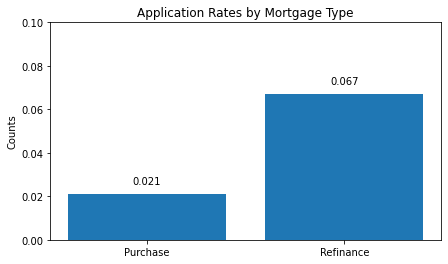

In [203]:
#visualizing application rates by mortgage type
plt.figure(figsize = (7,4))
_ = plt.bar(['Purchase','Refinance'], [0.021, 0.067])
plt.title('Application Rates by Mortgage Type')
plt.ylabel('Counts')
for x,y in zip(['Purchase','Refinance'], [0.021, 0.067]):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,0.1)
plt.show()

In [96]:
#looking at cash out amount by is cashout
data.groupby(['is_cashout'])[['cashout_amt']].mean()

,cashout_amt
is_cashout,
0,NaN
1,62835.323118


In [77]:
#looking at self_reported_credit value counts
data.self_reported_credit.value_counts()

EXCELLENT                  63086
SOMECREDITPROBLEMS         11963
MAJORCREDITPROBLEMS         7839
NOTPROVIDED                    5
LITTLEORNOCREDITHISTORY        4
Name: self_reported_credit, dtype: int64

In [78]:
#looking at estimated credit score by self reported credit score
data.groupby('self_reported_credit')[['est_credit_score']].mean()

,est_credit_score
self_reported_credit,
EXCELLENT,755.764258
LITTLEORNOCREDITHISTORY,719.000000
MAJORCREDITPROBLEMS,669.125016
NOTPROVIDED,731.000000
SOMECREDITPROBLEMS,702.866087


Text(0, 0.5, 'Count')

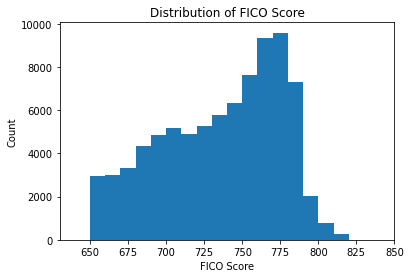

In [71]:
#looking at distribution of est credit score
_ = plt.hist(data.est_credit_score, bins = list(range(640,850,10)))
plt.title('Distribution of est_credit_score')
plt.xlabel('FICO Score')
plt.ylabel('Count')

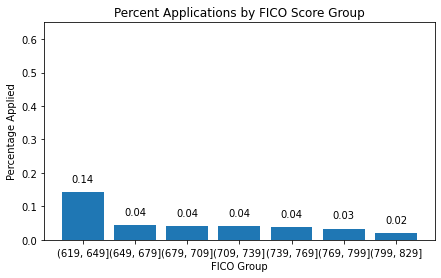

In [210]:
#creating FICO Score vs Application Rate chart

bins = list(range(499,839,30))
fico_groups = data.groupby([pd.cut(data.est_credit_score, bins)])['application'].sum() / data.groupby([pd.cut(data.est_credit_score, bins)])['application'].size()
fico_groups = pd.DataFrame(fico_groups).reset_index()

plt.figure(figsize = (7,4))
plt.bar(fico_groups['est_credit_score'].astype(str), fico_groups['application'])
plt.title('Percent Applications by FICO Score Group')
plt.xlabel('FICO Group')
plt.ylabel('Percentage Applied')
for x,y in zip(fico_groups['est_credit_score'].astype(str),fico_groups['application']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,.65)
plt.show()


#### Observation: Lead
Based on Lead being 1's for all observations, we can drop this variable

In [154]:
#dropping lead variable
print(data.lead.value_counts())
data.drop(['lead'], axis = 1, inplace = True)

1    82897
Name: lead, dtype: int64


In [79]:
#looking at binomial distribution of account variable
data.account.value_counts()

0    71416
1    11481
Name: account, dtype: int64

In [82]:
#looking at binomial distribution of lock variable
data.lock.value_counts()

0    81630
1     1267
Name: lock, dtype: int64

In [83]:
#looking at binomial distribution of fund variable
data.fund.value_counts()

0    82301
1      596
Name: fund, dtype: int64

In [84]:
#looking at binomial distribution of denied variable
data.denied.value_counts()

0    82626
1      271
Name: denied, dtype: int64

In [90]:
#looking at lead cost vs application cost 

data.groupby('application')[['cost']].agg({'cost':['mean','std','min','max']})

cost                   
                  mean        std min max
application                              
0            43.114960  12.642558  15  90
1            47.450237  14.019823  15  90

### Removing other Funnel Steps to Preempt Data Leakage

In [155]:
#looking at application rates at each funnel stage
data.groupby('application')[['account','lock','fund','denied']].mean()
#we are able to see account, lock, fund and denied would all introduce significant data leakage and therefore
#should be removed before moving on to next modeling stage 

,account,lock,fund,denied
application,,,,
0,0.104299,0.000025,0.000013,0.003311
1,1.000000,0.399684,0.187994,0.002212


In [339]:
#dropping variables that would introduce data leakage into dataset
data.drop(['account','lock','fund','denied'], axis = 1, inplace = True)

### Looking for Missing Values & Potential Outliers in Data

In [120]:
#looking for variables with missing values
missing_df = data.isna().sum().reset_index()
missing_df.rename({0:'count'}, axis = 1, inplace = True)
missing_df.loc[missing_df['count'] > 0]

,index,count
8,cashout_amt,55325


We can see all NA values for cashout_amt occur where that applicant wasn't looking to cashout part of their mortgage equity. We can therefore impute these to zero 

In [98]:
#looking at count of missing cashout_amt values for is_cashout = 0
data.loc[data['is_cashout'] == 0][['cashout_amt']].isna().sum()

cashout_amt    55325
dtype: int64

In [224]:
#looking at distribution of cashout amount missing values by mortgage type
data.groupby('mortgage_type')[['cashout_amt']].apply(lambda x: x.isna().sum())

,cashout_amt
mortgage_type,
0,51399
1,3926


In [163]:
#imputing cashout amt to zero
data['cashout_amt'].fillna(0, inplace = True)

#### *Observation: Correlation Heatmap*

Looking at our correlation heatmap between numeric variables vs application only shows a somewhat noticeable positive 
correlation between application and is_cashout variable, while cost and cashout_amt also have correlation values > |0.05| and loan_to_value displays weak negative correlation < |0.05| with regards to application. We therefore expect these variables to be important predictors later on in our model building phase

Text(0.5, 1.0, 'Numeric Variables Correlation Heatmap')

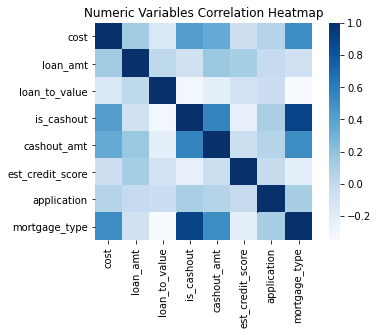

In [166]:
#creating correlation heatmap
ax = plt.axes()
#dummifying mortgage_type_refinance for purposes of the correlation heatmap
data['mortgage_type_refinance'] = (data['mortgage_type'] == 'refinance') * 1
data.rename({'mortgage_type_refinance':'mortgage_type'}, axis = 1, inplace = True)
correlation = data.select_dtypes(include = ['float64', 'int64']).corr()
sns.heatmap(correlation, square = True, cmap = 'Blues', ax = ax)
plt.title('Numeric Variables Correlation Heatmap')

### Feature Engineering

Outside research shows mortgage applications exhibit seasonality with higher application rates in January, February, March and April followed by seasonal increases in home sales in the spring and summer months. We will therefore create a new 'month' feature from our timestamp variable capturing when a lead was sent to Better

https://www.housingwire.com/articles/36855-heres-why-seasonality-matters-in-the-housing-market/

In [228]:
#creating month variable
data['lead_created_timestamp'] = pd.to_datetime(data['lead_created_timestamp'])
data['month'] = pd.DatetimeIndex(data['lead_created_timestamp']).month

(array([ 5250.,  4681., 10909., 13898., 14288., 16056., 16027.,   679.,
          448.,   661.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

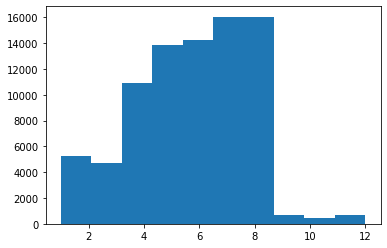

In [166]:
#already able to see significant seasonality in Leads forwarded in particular months
plt.hist(data['month'])

#### *Observation: Month*

Interestingly though there are higher numbers of applications in the spring and summer months, it appears the 
total conversion rate from lead to application is lower for those months 

In [172]:
#interestingly though there are higher numbers of applications in the spring and summer months, it appears the 
#total conversion rate from lead to application is lower for those months 
data.groupby('month')[['application']].agg({'application':['mean','std']})

application          
             mean       std
month                      
1        0.066246  0.248810
2        0.049473  0.216880
3        0.039094  0.193840
4        0.044092  0.205309
5        0.039358  0.194453
6        0.033735  0.180552
7        0.032573  0.177523
8        0.034754  0.183161
9        0.063328  0.243732
10       0.051339  0.220936
11       0.082949  0.276443
12       0.060811  0.239253

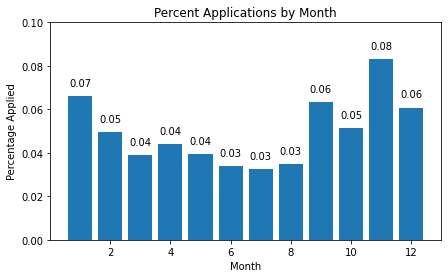

In [232]:
#visualizing applications rates by month

month_groups = data.groupby('month')[['application']].mean().reset_index()

#creating FICO Score vs Application Rate chart
plt.figure(figsize = (7,4))
plt.bar(month_groups['month'], month_groups['application'])
plt.title('Percent Applications by Month')
plt.xlabel('Month')
plt.ylabel('Percentage Applied')
for x,y in zip(month_groups['month'],month_groups['application']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,.1)
plt.show()

In [ ]:
#mapping lead timestamp to month variable
month_dict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',
              8:'August',9:'September',10:'October',11:'November',12:'December'}
data['month'] = data['month'].replace(month_dict)

In [340]:
#dummifying our categorical variables for model training
data = pd.get_dummies(data, drop_first = True)

### Model Training

We train LogisticRegression, RandomForestClassifier and XGBoost Classifier models in order to see the relative strengths and weaknesses of each modeling framework on our dataset. We adjust our class weights and stratify our k-fold cross validation to account for the high class imbalance in the application variable and tune our models to optimize for recall given the assumed higher cost of False Negatives vs False Positives in this dataset.

In [344]:
#splitting data
y = data['application']
X = data.loc[:, data.columns != 'application']
X.drop(['lead_created_timestamp','cost'], axis = 1, inplace = True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
#setting class weights and instantiating Random Forests model
class_weights = {0:3165, 1:79732}
rfc = RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_depth = 5, class_weight = class_weights)

In [190]:
#training Random Forests model
rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 3165, 1: 79732}, max_depth=5,
                       n_estimators=300)

##### Cross Validating our RFC Scores with stratification

In [229]:
#stratified KFold cross validation
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=4)

i = 1
cv_score_rfc = []
for train_index, test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    rfc = RandomForestClassifier(n_estimators = 400, criterion = 'gini', max_depth = 5, class_weight = class_weights)
    rfc.fit(xtr,ytr)
    rfc_predictions = rfc.predict(xvl)
    rocaucscore = roc_auc_score(yvl,rfc_predictions)
    recallscore = recall_score(yvl,rfc_predictions)
    print('ROC AUC score:',rocaucscore)
    print('Recall score:',recallscore)
    cv_score_rfc.append(score)    
    i+=1

1 of KFold 5
ROC AUC score: 0.6526916619834007
Recall score: 0.6635071090047393
2 of KFold 5
ROC AUC score: 0.6468296294667238
Recall score: 0.655608214849921
3 of KFold 5
ROC AUC score: 0.6364676379146127
Recall score: 0.6382306477093207
4 of KFold 5
ROC AUC score: 0.660309111973289
Recall score: 0.6824644549763034
5 of KFold 5
ROC AUC score: 0.63924354491036
Recall score: 0.65086887835703


In [207]:
#looking at RFC feature importances
sorted(list(zip(rfc.feature_importances_, X.columns.values)), key = lambda x: x[0], reverse = True)

[(0.30228282754071273, 'mortgage_type_refinance'),
 (0.19152728758673318, 'cashout_amt'),
 (0.17560081823694035, 'is_cashout'),
 (0.12715094889820575, 'loan_to_value'),
 (0.041503216855854376, 'loan_amt'),
 (0.034603587508925684, 'est_credit_score'),
 (0.024437230631839522, 'state_TX'),
 (0.016617418658619067, 'month_August'),
 (0.011120832545764863, 'state_WA'),
 (0.009634743244446964, 'state_GA'),
 (0.007827716460285055, 'self_reported_credit_SOMECREDITPROBLEMS'),
 (0.00710771542008436, 'month_February'),
 (0.00647316810714335, 'month_July'),
 (0.005973973355627842, 'month_January'),
 (0.004758276576368949, 'state_IL'),
 (0.004700321294699739, 'state_CA'),
 (0.0032025868466291655, 'self_reported_credit_MAJORCREDITPROBLEMS'),
 (0.003171100245530508, 'month_May'),
 (0.0023923896188268873, 'month_March'),
 (0.0023770588890522967, 'month_September'),
 (0.00185448413202365, 'month_June'),
 (0.0016920379647602725, 'state_CT'),
 (0.0014478096808860402, 'state_OR'),
 (0.0014461276701975036, 

#### Logistic Regression

In [47]:
#stratified train test splits for logistic regression

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=4)

i = 1
cv_score = []
for train_index, test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(class_weight = class_weights, max_iter = 500, solver = 'liblinear')
    lr.fit(xtr,ytr)
    rocaucscore = roc_auc_score(yvl,lr.predict(xvl))
    recallscore = recall_score(yvl, lr.predict(xvl))
    print('ROC AUC score:',rocaucscore)
    print('Recall score:',recallscore)
    cv_score.append(rocaucscore)    
    i+=1

1 of KFold 5
ROC AUC score: 0.6531608306385359
Recall score: 0.6714060031595577
2 of KFold 5
ROC AUC score: 0.650515020579128
Recall score: 0.6682464454976303
3 of KFold 5
ROC AUC score: 0.6345743008245245
Recall score: 0.6350710900473934
4 of KFold 5
ROC AUC score: 0.6589114743301296
Recall score: 0.6777251184834123
5 of KFold 5
ROC AUC score: 0.64179996112472
Recall score: 0.6635071090047393


In [48]:
#zipping our log odds and feature names 
logodds = sorted(list(zip(lr.coef_.tolist()[0], X.columns.values)), key = lambda x: x[0], reverse = True)

In [84]:
#interpreting Logistic Regression coefficients 

def convert_log_odds(list1):
    
    answerlist = []
    
    for x in list1:
        answerlist.append(tuple([math.exp(x[0]), x[1]]))
    
    return sorted(answerlist, key = lambda x: x[0], reverse = True)

convert_log_odds(logodds)


[(2.289174506676853, 'mortgage_type_refinance'),
 (1.5503547797452302, 'is_cashout'),
 (1.363407670181051, 'state_GA'),
 (1.2398128614391104, 'state_WA'),
 (1.1455799260640287, 'month_January'),
 (1.1085897990590188, 'state_CT'),
 (1.0960814295563108, 'state_DC'),
 (1.0412818041734166, 'state_OR'),
 (1.033319910868462, 'state_IA'),
 (1.0324815241953675, 'month_November'),
 (1.0305210861616128, 'month_February'),
 (1.029810580370587, 'month_March'),
 (1.0215801808827887, 'month_September'),
 (1.0019248541848786, 'state_SD'),
 (1.000593294058737, 'month_December'),
 (1.0001531110018842, 'est_credit_score'),
 (0.9999999954742796, 'loan_amt'),
 (0.999999747408583, 'cashout_amt'),
 (0.9986424955077189, 'self_reported_credit_LITTLEORNOCREDITHISTORY'),
 (0.9979415677719945, 'state_CO'),
 (0.9963860308469918, 'self_reported_credit_NOTPROVIDED'),
 (0.9944258517718475, 'loan_to_value'),
 (0.9924884748591437, 'state_FL'),
 (0.9912069172304339, 'state_MS'),
 (0.9604195363573524, 'state_NJ'),
 (0.9

In [ ]:
#leveraging statsmodel logit 
X2 = X.append(y)

m1 = smf.logit(
  formula='application ~ .',
  data=X2) \
.fit()

In [76]:
X1 = sm.add_constant(X)
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y, test_size = 0.3, )

res2 = sm.Logit(y, X1).fit_regularized(L1_wt=0.0, alpha=0.1)

res2.summary()


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1544550143596133
            Iterations: 728
            Function evaluations: 761
            Gradient evaluations: 728


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 22 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            application   No. Observations:                82897
Model:                          Logit   Df Residuals:                    82857
Method:                           MLE   Df Model:                           39
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                 0.04736
Time:                        00:30:15   Log-Likelihood:                -12803.
converged:                       True   LL-Null:                       -13439.
Covariance Type:            nonrobust   LLR p-value:                1.103e-241
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -4.3960      0.575     -7.647      0.000      -5.523      -3.269
loan_amt                                       6.05e-08   1.04e-07      0.582      0.561   -1.43e-07    2.64e-07
loan_to_value                                   -0.0035      0.001     -2.860      0.004      -0.006      -0.001
is_cashout                                       0.1401      0.094      1.496      0.135      -0.043       0.324
cashout_amt                                  -2.003e-07   3.54e-07     -0.566      0.571   -8.94e-07    4.93e-07
est_credit_score                                 0.0015      0.001      2.067      0.039    7.71e-05       0.003
mortgage_type_refinance                          1.1083      0.095     11.710      0.000       0.923       1.294
state_CA                                        -0.2957      0.094     -3.142      0.002      -0.480      -0.111
state_CO                                        -0.0316      0.109     -0.290      0.772      -0.245       0.182
state_CT                                         0.0710      0.124      0.574      0.566      -0.172       0.314
state_DC                                         0.3847      0.217      1.770      0.077      -0.041       0.811
state_FL                                         0.0179      0.092      0.194      0.846      -0.163       0.199
state_GA                                         0.2246      0.100      2.248      0.025       0.029       0.420
state_IA                                         0.3015      0.436      0.691      0.489      -0.553       1.156
state_IL                                        -0.2532      0.136     -1.866      0.062      -0.519       0.013
state_MI                                        -0.1669      0.148     -1.125      0.261      -0.458       0.124
state_MS                                        -0.0202      0.590     -0.034      0.973      -1.177       1.137
state_NC                                        -0.0799      0.110     -0.725      0.469      -0.296       0.136
state_NJ                                        -0.0664      0.117     -0.566      0.572      -0.297       0.164
state_OR                                         0.1590      0.117      1.363      0.173      -0.070       0.388
state_PA                                        -0.1720      0.114     -1.506      0.132      -0.396       0.052
state_SD                                         0.0029      1.043      0.003      0.998      -2.042       2.047
state_TN                                        -0.1495      0.153     -0.978      0.328      -0.449       0.150
state_TX                                        -0.1313      0.101     -1.306      0.192      -0.328       0.066
state_WA                                         0.1938      0.102      1.906      0.057      -0.006       0.393
self_reported_credit_LITTLEORNOCREDITHISTORY    -0.0451      3.096     -0.015

#### Business Lead Target Recommendations / Interpretation of our Logistic Regression coefficients

1. People looking to refinance mortgages (statistically significant at 5% level in Logistic Regression and in top 10 feature importances for RandomForestsClassifier)
1. People with highr FICO scores (10 point increase in FICO score = 1.50% increase in odds of applying) (statistically significant at 5% level in Logistic Regression and in top 10 feature importances for RandomForestsClassifier)
1. People with lower loan to value (1% increase in loan to value = 0.35% decrease in application rates)

1. Months of June, July & August being 25-35% lower application rate months

In [85]:
logodds_log_reg = list(zip(res2.params, X1.columns.values))
convert_log_odds(logodds_log_reg)

[(3.029197534023662, 'mortgage_type_refinance'),
 (1.4691851159465115, 'state_DC'),
 (1.3519272244528537, 'state_IA'),
 (1.2518358285799844, 'state_GA'),
 (1.213853575830031, 'state_WA'),
 (1.1723484994273896, 'state_OR'),
 (1.1504166156505333, 'is_cashout'),
 (1.0735985702611883, 'state_CT'),
 (1.0575082945998078, 'self_reported_credit_MAJORCREDITPROBLEMS'),
 (1.0568111657104964, 'self_reported_credit_SOMECREDITPROBLEMS'),
 (1.0180453436848205, 'state_FL'),
 (1.002898837785275, 'state_SD'),
 (1.0014922743856671, 'est_credit_score'),
 (1.00000006050311, 'loan_amt'),
 (0.9999997996544198, 'cashout_amt'),
 (0.996485481958039, 'loan_to_value'),
 (0.9800198896012599, 'state_MS'),
 (0.9688799815555456, 'state_CO'),
 (0.955946947745631, 'self_reported_credit_LITTLEORNOCREDITHISTORY'),
 (0.9357284846937997, 'state_NJ'),
 (0.9231821143064634, 'state_NC'),
 (0.8769331152140368, 'state_TX'),
 (0.8665706019801536, 'month_November'),
 (0.8611178807952764, 'state_TN'),
 (0.8523006541269581, 'month_

#### Applying XGBoostClassifier

In [ ]:
#nstantiating XGBoostClassifier model and defining parameters 

xgboost = XGBClassifier(silent=False, 
                      scale_pos_weight=40,
                      learning_rate=0.005,  
                      colsample_bytree = 0.8,
                      subsample = 0.6,
                      objective='binary:logistic', 
                      n_estimators=300, 
                      reg_alpha = 0.2,
                      max_depth=4, 
                      gamma=10)

#training
xgboost.fit(x_train, y_train)

In [131]:
#looking at xgboost feature importances
sorted(list(zip(xgboost.feature_importances_, X.columns)), key = lambda x: x[0], reverse = True)

[(0.31713945, 'mortgage_type_refinance'),
 (0.19705112, 'is_cashout'),
 (0.037413534, 'cashout_amt'),
 (0.03331772, 'month_August'),
 (0.022117905, 'est_credit_score'),
 (0.021000309, 'loan_amt'),
 (0.018056326, 'month_February'),
 (0.017587293, 'loan_to_value'),
 (0.016924622, 'month_May'),
 (0.016413439, 'state_CA'),
 (0.015975708, 'state_FL'),
 (0.015276485, 'state_MI'),
 (0.014628007, 'state_GA'),
 (0.014450567, 'state_IL'),
 (0.013595735, 'state_NC'),
 (0.013463715, 'month_July'),
 (0.01346281, 'self_reported_credit_MAJORCREDITPROBLEMS'),
 (0.0133511005, 'state_TX'),
 (0.013329883, 'month_June'),
 (0.01245326, 'state_TN'),
 (0.011953969, 'state_SD'),
 (0.011498238, 'self_reported_credit_SOMECREDITPROBLEMS'),
 (0.011414428, 'month_January'),
 (0.0113568595, 'month_October'),
 (0.01134368, 'month_September'),
 (0.011310675, 'state_PA'),
 (0.010781305, 'month_November'),
 (0.010611533, 'state_WA'),
 (0.010412822, 'state_CO'),
 (0.009736878, 'state_OR'),
 (0.009567469, 'state_CT'),
 (

In [106]:
#model performance function

def model_performance(model, cv = 5):
    
    model1 = str(model)
    print('Model recall mean is',np.mean(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'recall')))
    print('Model precision mean is',np.mean(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'precision')))
    print('Model roc_auc mean is',np.mean(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'roc_auc')))
    
    print('Model recall std is',np.std(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'recall')))
    print('Model precision std is',np.std(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'precision')))
    print('Model roc_auc std is',np.std(cross_val_score(model, x_test, y_test, cv = cv, scoring = 'roc_auc')))


In [ ]:
#looking at xgboost model performance metrics
model_performance(xgboost, cv = 5)

In [134]:
#looking at xgboost confusion matrix
confusion_matrix(y_test, xgboost.predict(x_test))

array([[10821, 13128],
       [  166,   755]])

In [107]:
#looking at xgboost model performance metrics
model_performance(lr)

Model recall mean is 0.6525146886016452
Model precision mean is 0.06480744152106907
Model roc_auc mean is 0.6710890558825211
Model recall std is 0.030341549231425787
Model precision std is 0.0019505953151272288
Model roc_auc std is 0.019372752728568393


In [ ]:
#getting predicted probabilities for each of our models
probas_lr = lr.predict_proba(x_test)[:, 1]
probas_rfc = rfc.predict_proba(x_test)[:, 1]
probas_xgb = xgboost.predict_proba(x_test)[:, 1]

#### Tuning RandomForest Classifier

In [238]:
#grid search cv on RandomForests to see if can inrease score
param_grid = { 
    'max_depth': [5,6,7],
    'min_samples_split': [2,3,4]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring = 'recall', cv= 5)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

{'max_depth': 5, 'min_samples_split': 3}


In [239]:
#same score context
print(CV_rfc.best_score_)

0.656868437798282


In [ ]:
#using our updated RandomForestClassifier
rfc2 = RandomForestClassifier(n_estimators = 400, criterion = 'gini', max_depth = 5, 
                              min_samples_split = 3, class_weight = {0:1,1:40})
rfc2.fit(x_train, y_train)

In [135]:
#looking at rfc model performance
model_performance(rfc2)

Model recall mean is 0.7382491186839013
Model precision mean is 0.06173420556649811
Model roc_auc mean is 0.6845407491235491
Model recall std is 0.03988636871993376
Model precision std is 0.0031970092972611977
Model roc_auc std is 0.01763025932900722


#### Creating ROC_AUC plot

In [136]:
#getting predicted probabilities for each of our models
probas_lr = lr.predict_proba(x_test)[:, 1]
probas_rfc = rfc2.predict_proba(x_test)[:, 1]
probas_xgb = xgboost.predict_proba(x_test)[:, 1]

In [137]:
#defining prediction function
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

In [138]:
#LogisticRegression
roc_values_lr = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_lr)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_lr.append([tpr, fpr])
tpr_values_lr, fpr_values_lr = zip(*roc_values_lr)

In [139]:
#RandomForestClassifier
roc_values_rfc = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_rfc)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_rfc.append([tpr, fpr])
tpr_values_rfc, fpr_values_rfc = zip(*roc_values_rfc)

In [140]:
#XGBClassifier
roc_values_xgb = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas_xgb)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values_xgb.append([tpr, fpr])
tpr_values_xgb, fpr_values_xgb = zip(*roc_values_xgb)

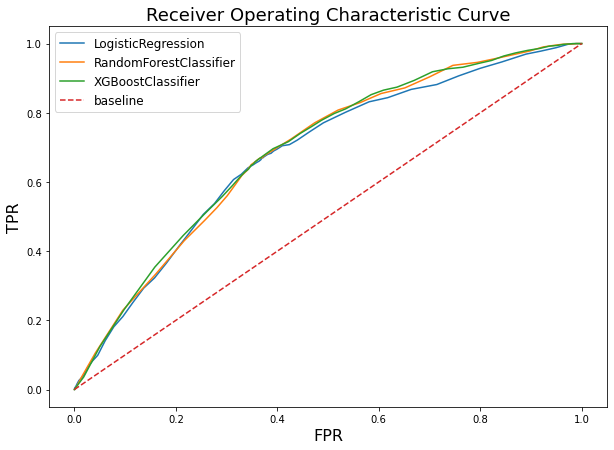

In [141]:
#creating ROC_AUC plot
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values_lr, tpr_values_lr, label = 'LogisticRegression')
ax.plot(fpr_values_rfc, tpr_values_rfc, label = 'RandomForestClassifier')
ax.plot(fpr_values_xgb, tpr_values_xgb, label = 'XGBoostClassifier')
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
ax.legend()
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);


### Optimizing Lead Cost

We create a Ranking Function based on predict_proba probabilities

In [299]:
#getting xgboost predicted probabilities
preds = xgboost.predict_proba(x_test)
preds = pd.DataFrame(preds, columns = ['No Application','Application'])

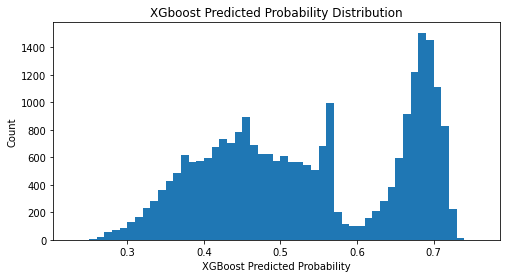

In [368]:
#visualizing distribution of predicted probabilities
preds = pd.DataFrame(preds)
plt.figure(figsize = (8,4))
_ = plt.hist(preds.iloc[:, 1], bins = [x/100 for x in range(23,77,1)])
plt.xlabel('XGBoost Predicted Probability')
plt.ylabel('Count')
plt.title('XGboost Predicted Probability Distribution')
plt.show()
#we will need to leverage qcut binning to ensure same numbers of customers are in each cost bin

In [330]:
#concatenating pred probs to x_test
x_test = pd.concat([x_test, preds], axis = 1)

In [358]:
#creating our bins with pandas qcut function
bin_labels = list(range(15,91))
preds2 = preds
preds2['pred_cost'] = pd.qcut(preds2['Application'],
                              q=76,
                              labels=bin_labels)
preds2.pred_cost = preds2.pred_cost.astype(np.int64)

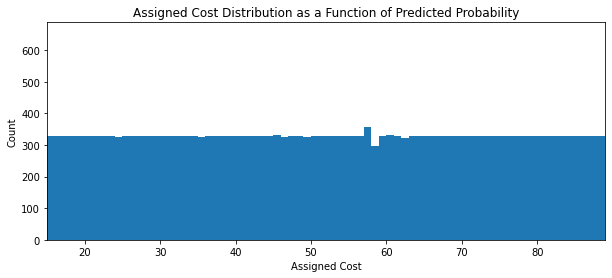

In [371]:
#visualizing distribution of pred cost with equal numbers of leads in each bucket
plt.figure(figsize = (10,4))
_ = plt.hist(preds['pred_cost'], bins = [x for x in range(15,91,1)])
plt.xlabel('Assigned Cost')
plt.ylabel('Count')
plt.title('Assigned Cost Distribution as a Function of Predicted Probability')
plt.xlim(15,89)
plt.show()
